In [202]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.discriminant_analysis import StandardScaler
from captum.attr import IntegratedGradients
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [203]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# For deterministic behavior in CUDA (if used)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [204]:
class CNN_1D(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

## Task 1: MCI vs. AD

In [183]:
def compute_metrics(y_true, y_pred,positive_class):
    """
    Computes sensitivity (recall), specificity for ONE selected class.
    y_true and y_pred must be 1-D numpy arrays.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Binary mask: positive_class vs all others
    pos = (y_true == positive_class)
    pred_pos = (y_pred == positive_class)

    # True positives, false negatives, true negatives, false positives
    TP = np.sum(pos & pred_pos)
    FN = np.sum(pos & (~pred_pos))
    TN = np.sum((~pos) & (~pred_pos))
    FP = np.sum((~pos) & pred_pos)

    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)

    return sensitivity, specificity


def train_one_fold(model, train_loader, val_loader, y_train_all, epochs=50,device=device):
    model.to(device)
    # compute class weights based on training fold only
    classes = np.unique(y_train_all)
    cls_weights = compute_class_weight('balanced', classes=classes, y=y_train_all)
    cls_weights = torch.tensor(cls_weights, dtype=torch.float32, device=device)

    criterion = nn.CrossEntropyLoss(weight=cls_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_val_acc = 0
    best_state = None

    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # --- validation ---
        model.eval()
        val_loss_total = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                pred_labels = preds.argmax(dim=1)
                loss = criterion(preds, yb)
                val_loss_total += loss.item() * xb.size(0)
                correct += (pred_labels == yb).sum().item()
                total += len(yb)
        val_loss = val_loss_total / total
        val_acc = correct / total
        sensitivity, specificity = compute_metrics(yb.numpy(), pred_labels.numpy(), positive_class=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
        
        best_matrix = {
            'val_acc': val_acc,
            'val_loss': val_loss,
            'sensitivity': sensitivity,
            'specificity': specificity
        }

    model.load_state_dict(best_state)
    return model, best_matrix

def cross_validate_cnn(X, y, k_folds=5, epochs=50, device=device):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_models = []
    fold_metrics = []

    for train_idx, val_idx in kf.split(X):
        X_train = torch.tensor(X[train_idx], dtype=torch.float32).unsqueeze(1).to(device)
        y_train = torch.tensor(y[train_idx], dtype=torch.long).to(device)
        X_val = torch.tensor(X[val_idx], dtype=torch.float32).unsqueeze(1).to(device)
        y_val = torch.tensor(y[val_idx], dtype=torch.long).to(device)

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

        model = CNN_1D(num_classes=len(np.unique(y))).to(device)
        model, val_acc = train_one_fold(model, train_loader, val_loader, y[train_idx], epochs, device)

        fold_models.append(model)
        fold_metrics.append(val_acc)
        print(f"Fold Done (val acc = {val_acc['val_acc']:.3f}, val loss = {val_acc['val_loss']:.3f}, sensitivity = {val_acc['sensitivity']:.3f}, specificity = {val_acc['specificity']:.3f})")

    mean_val_acc = np.mean([m['val_acc'] for m in fold_metrics])
    mean_val_loss = np.mean([m['val_loss'] for m in fold_metrics])
    mean_sens = np.mean([m['sensitivity'] for m in fold_metrics])
    mean_spec = np.mean([m['specificity'] for m in fold_metrics])

    print(f"\n=== Cross-Validation Summary ({k_folds}-fold) ===")
    print(f"Mean Val Acc: {mean_val_acc:.3f}, Mean Loss: {mean_val_loss:.3f}, Mean Sensitivity: {mean_sens:.3f}, Mean Specificity: {mean_spec:.3f}")

    return fold_models

def compute_global_ig(fold_models, X, y, device=device):
    all_attr = []

    print("Computing Integrated Gradients across folds...")

    # loop over folds with tqdm
    for fold_i, model in enumerate(tqdm(fold_models, desc="Folds"), 1):

        model.eval().to(device)
        ig = IntegratedGradients(model)

        fold_attr = []

        # tqdm over samples
        for i in tqdm(range(len(X)), desc=f"Fold {fold_i} samples", leave=False):
            inp = torch.tensor(X[i:i+1], dtype=torch.float32).unsqueeze(1).to(device)

            attr, _ = ig.attribute(
                inp,
                target=int(y[i]),
                return_convergence_delta=True
            )

            fold_attr.append(attr.squeeze().detach().cpu().numpy())

        fold_attr = np.vstack(fold_attr)  # (N, G)
        all_attr.append(np.mean(np.abs(fold_attr), axis=0))

    # Final averaged IG score across folds
    return np.mean(np.vstack(all_attr), axis=0)


def find_optimal_k(ig_scores,k):
    sorted_scores = np.sort(ig_scores)[::-1]

    # compute curvature (second finite difference)
    curvature = np.diff(sorted_scores, n=2)

    # elbow at max curvature
    elbow_k = np.argmax(np.abs(curvature)) + 2   # +2 because of second diff

    # Plot elbow curve
    plt.figure(figsize=(6,4))
    plt.plot(sorted_scores, label="IG scores (sorted)")
    plt.axvline(k, linestyle="--", label=f"k={k}", color="r")
    plt.legend()
    plt.title("IG-Based Elbow Method for Gene Selection")
    plt.xlabel("Gene Rank")
    plt.ylabel("IG Score")
    plt.show()

    return elbow_k

def reduce_genes(X, ig_scores, k):
    top_idx = np.argsort(ig_scores)[::-1][:k]
    return X[:, top_idx], top_idx

def train_final_cnn_cv(X_reduced, y_np, epochs=20, k_folds=5, device=device):
    print("---- Final Cross-Validation on IG-Selected Genes ----")
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_models = []
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_reduced), 1):
        X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=16)

        model = CNN_1D(num_classes=len(np.unique(y_np))).to(device)
        model, best_matrix = train_one_fold(model, train_loader, val_loader, y_train, epochs=epochs, device=device)

        print(f"Fold Done (val acc = {best_matrix['val_acc']:.3f}, val loss = {best_matrix['val_loss']:.3f}, sensitivity = {best_matrix['sensitivity']:.3f}, specificity = {best_matrix['specificity']:.3f})")

        fold_models.append(model)
        fold_metrics.append(best_matrix)

    # Average metrics across folds
    mean_val_acc = np.mean([m['val_acc'] for m in fold_metrics])
    mean_sens = np.mean([m['sensitivity'] for m in fold_metrics])
    mean_spec = np.mean([m['specificity'] for m in fold_metrics])

    print(f"\n=== Cross-Validation Summary ({k_folds}-fold) ===")
    print(f"Mean Val Acc: {mean_val_acc:.3f}, Mean Sensitivity: {mean_sens:.3f}, Mean Specificity: {mean_spec:.3f}")

    return fold_models


/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_65674/1511652096.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_int = y.replace(label_map).astype(int).values   # numpy array


Training data shape: (116, 2000), Labels shape: (116,)
Classify:  (array([0, 1]), array([49, 67])) clases
Fold Done (val acc = 0.542, val loss = 0.796, sensitivity = 0.667, specificity = 1.000)
Fold Done (val acc = 0.391, val loss = 0.944, sensitivity = 1.000, specificity = 0.000)
Fold Done (val acc = 0.435, val loss = 0.802, sensitivity = 0.333, specificity = 0.500)
Fold Done (val acc = 0.565, val loss = 0.741, sensitivity = 0.000, specificity = 1.000)
Fold Done (val acc = 0.478, val loss = 0.743, sensitivity = 0.333, specificity = 1.000)

=== Cross-Validation Summary (5-fold) ===
Mean Val Acc: 0.482, Mean Loss: 0.805, Mean Sensitivity: 0.467, Mean Specificity: 0.700
Computing Integrated Gradients across folds...


Folds: 100%|██████████| 5/5 [07:48<00:00, 93.61s/it]


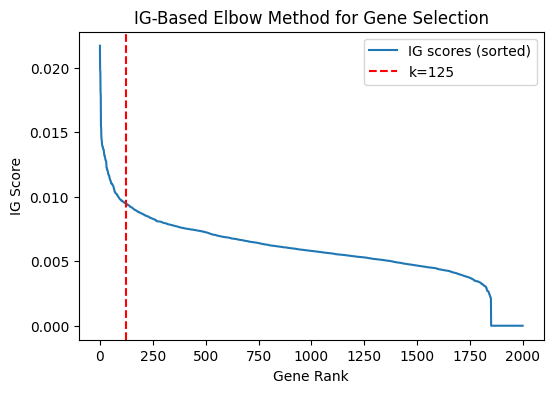

Optimal k (elbow method): 6
---- Final Cross-Validation on IG-Selected Genes ----
Fold Done (val acc = 0.750, val loss = 0.638, sensitivity = 0.833, specificity = 0.500)
Fold Done (val acc = 0.435, val loss = 1.104, sensitivity = 1.000, specificity = 0.500)
Fold Done (val acc = 0.565, val loss = 0.786, sensitivity = 0.667, specificity = 0.750)
Fold Done (val acc = 0.565, val loss = 0.815, sensitivity = 0.667, specificity = 1.000)
Fold Done (val acc = 0.652, val loss = 0.671, sensitivity = 1.000, specificity = 0.250)

=== Cross-Validation Summary (5-fold) ===
Mean Val Acc: 0.593, Mean Sensitivity: 0.833, Mean Specificity: 0.600


In [191]:
train_data = pd.read_csv('train_mi_data.csv', index_col=None)

# Separate features (genes) and labels
X_df = train_data.drop(columns=['sample', 'disease_state'])

label_map = {
    'S-MCI': 1,
    'P-MCI': 1,
    'AD': 0
}

y = train_data['disease_state']
y_int = y.replace(label_map).astype(int).values   # numpy array
X_np_raw = X_df.values.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np_raw)         # already numpy
print(f"Training data shape: {X_scaled.shape}, Labels shape: {y_int.shape}")
X_np = X_scaled.astype(np.float32)     # safe conversion
y_np = y_int.astype(np.int64)
print(f"Classify:  {np.unique(y_np, return_counts=True)} clases")

# Step 1 — CV to train multiple CNNs
fold_models = cross_validate_cnn(X_np, y_np, k_folds=5, epochs=50)

# Step 2 — Compute global IG scores
ig_scores = compute_global_ig(fold_models, X_np, y_np)

# Step 3 — Automatic optimal k using IG-elbow
k_opt = find_optimal_k(ig_scores, 125)
print(f"Optimal k (elbow method): {k_opt}")

# Step 4 — Reduce dataset to top-k genes
X_reduced, selected_idx = reduce_genes(X_np, ig_scores, 125)

# Step 5 — Train final CNN on IG-selected genes
final_model = train_final_cnn_cv(X_reduced, y_np, epochs=50)


In [192]:
gene_cols = X_df.columns.tolist()

top_genes = [gene_cols[i] for i in selected_idx]
print(f"Top IG-selected genes: {len(top_genes)} \n {top_genes}")
sorted_ig = np.sort(ig_scores[selected_idx])[::-1]
top_k_task1 = pd.DataFrame({'gene_id': top_genes, 'ig_score': sorted_ig[:200]})

top_k_task1.to_csv('top_ig_genes_task1.csv', index=False)

Top IG-selected genes: 125 
 ['ENSG00000284631', 'ENSG00000179546', 'ENSG00000279076', 'ENSG00000183067', 'ENSG00000214026', 'ENSG00000164107', 'ENSG00000176988', 'ENSG00000188984', 'ENSG00000204595', 'ENSG00000196900', 'ENSG00000196620', 'ENSG00000094963', 'ENSG00000242498', 'ENSG00000164112', 'ENSG00000129864', 'ENSG00000280416', 'ENSG00000189171', 'ENSG00000125753', 'ENSG00000277150', 'ENSG00000175619', 'ENSG00000154646', 'ENSG00000172037', 'ENSG00000072041', 'ENSG00000211967', 'ENSG00000122145', 'ENSG00000169429', 'ENSG00000186470', 'ENSG00000094661', 'ENSG00000101680', 'ENSG00000259303', 'ENSG00000250506', 'ENSG00000147649', 'ENSG00000166363', 'ENSG00000178928', 'ENSG00000183054', 'ENSG00000074416', 'ENSG00000179344', 'ENSG00000141338', 'ENSG00000186340', 'ENSG00000101144', 'ENSG00000185220', 'ENSG00000146453', 'ENSG00000167264', 'ENSG00000185101', 'ENSG00000002746', 'ENSG00000175325', 'ENSG00000125734', 'ENSG00000137090', 'ENSG00000176125', 'ENSG00000166840', 'ENSG00000121207', '

### Evaluation

Test data shape: (41, 125), Labels shape: (41,)
Classify:  (array([0, 1]), array([21, 20])) clases
Test Accuracy: 0.3902439024390244
Sensitivity: 0.0
Specificity: 0.9999999997560975
Confusion Matrix:
 [[ 6 15]
 [10 10]]


/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_65674/2965510078.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_int = y.replace(label_map).astype(int).values   # numpy array


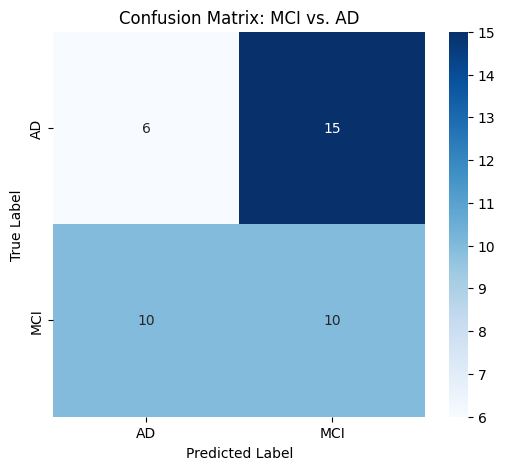

In [193]:
from sklearn.metrics import confusion_matrix, accuracy_score

def test_cnn(model, test_loader, device, positive_class=2):
    """
    Evaluates a trained CNN model on test data.

    Args:
        model: trained PyTorch model
        test_loader: DataLoader for test dataset
        device: 'cuda' or 'cpu'
        positive_class: int, class for sensitivity/specificity

    Returns:
        metrics: dict with accuracy, sensitivity, specificity, confusion matrix
        y_true: true labels (numpy)
        y_pred: predicted labels (numpy)
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Sensitivity & Specificity for the selected class
    pos_mask = (y_true == positive_class)
    pred_pos_mask = (y_pred == positive_class)

    TP = np.sum(pos_mask & pred_pos_mask)
    FN = np.sum(pos_mask & (~pred_pos_mask))
    TN = np.sum((~pos_mask) & (~pred_pos_mask))
    FP = np.sum((~pos_mask) & pred_pos_mask)

    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    metrics = {
        "accuracy": acc,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm
    }

    return metrics, y_true, y_pred

# Load and preprocess test data
test_data = pd.read_csv('test_mi_data.csv', index_col=None)
X_df = test_data.drop(columns=['sample', 'disease_state'])
X_df = X_df[top_genes]  # select only IG-chosen genes
label_map = {
    'MCI':1,
    'AD': 0
}
y = test_data['disease_state']
y_int = y.replace(label_map).astype(int).values   # numpy array

X_np_raw = X_df.values.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np_raw)         # already numpy
print(f"Test data shape: {X_scaled.shape}, Labels shape: {y_int.shape}")
X_test_np = X_scaled.astype(np.float32)     # safe conversion
y_test_np = y_int.astype(np.int64)
print(f"Classify:  {np.unique(y_test_np, return_counts=True)} clases")


# Assuming X_test_np, y_test_np are NumPy arrays
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Load best model
model = final_model[0]
model.to(device)

metrics, y_true, y_pred = test_cnn(model, test_loader, device, positive_class=2)

print("Test Accuracy:", metrics["accuracy"])
print("Sensitivity:", metrics["sensitivity"])
print("Specificity:", metrics["specificity"])
print("Confusion Matrix:\n", metrics["confusion_matrix"])

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(metrics["confusion_matrix"], annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"AD", f"MCI"],
            yticklabels=[f"AD", f"MCI"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: MCI vs. AD')
plt.show()


## Task 2: S-MCI vs P-MCI vs AD

In [212]:
def compute_metrics(y_true, y_pred, classes):
    """
    Returns overall accuracy, per-class sensitivity and specificity
    as dictionaries/matrix.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    sens = {}  # sensitivity / recall per class
    spec = {}  # specificity per class

    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sens[cls] = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec[cls] = TN / (TN + FP) if (TN + FP) > 0 else 0

    return  sens, spec


def train_one_fold(model, train_loader, val_loader, y_train_all, epochs=50, device=device):
    model.to(device)
    classes = np.unique(y_train_all)

    # class weights
    cls_weights = compute_class_weight('balanced', classes=classes, y=y_train_all)
    cls_weights = torch.tensor(cls_weights, dtype=torch.float32, device=device)

    criterion = nn.CrossEntropyLoss(weight=cls_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_val_acc = 0
    best_state = None

    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # --- VALIDATION ---
        model.eval()
        val_loss_total = 0
        correct = 0
        total = 0

        all_true = []
        all_pred = []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                pred_labels = preds.argmax(dim=1)

                loss = criterion(preds, yb)

                val_loss_total += loss.item() * xb.size(0)
                correct += (pred_labels == yb).sum().item()
                total += len(yb)

                all_true.append(yb.cpu().numpy())
                all_pred.append(pred_labels.cpu().numpy())

        # concatenate all validation predictions
        y_true_all = np.concatenate(all_true)
        y_pred_all = np.concatenate(all_pred)

        val_loss = val_loss_total / total
        val_acc = correct / total

        # compute 3-class metrics
        sensitivity, specificity = compute_metrics(
            y_true_all, 
            y_pred_all, 
            classes=classes
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

        best_matrix = {
            'val_acc': val_acc,
            'val_loss': val_loss,
            'sensitivity': sensitivity,
            'specificity': specificity
        }

    model.load_state_dict(best_state)
    return model, best_matrix


def cross_validate_cnn(X, y, k_folds=5, epochs=50, device=device):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_models = []
    fold_metrics = []

    for train_idx, val_idx in kf.split(X):
        X_train = torch.tensor(X[train_idx], dtype=torch.float32).unsqueeze(1).to(device)
        y_train = torch.tensor(y[train_idx], dtype=torch.long).to(device)
        X_val = torch.tensor(X[val_idx], dtype=torch.float32).unsqueeze(1).to(device)
        y_val = torch.tensor(y[val_idx], dtype=torch.long).to(device)

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

        model = CNN_1D(num_classes=len(np.unique(y))).to(device)
        model, metrics = train_one_fold(model, train_loader, val_loader, y[train_idx], epochs, device)

        # Convert dicts → numpy array for averaging
        sens_values = np.array(list(metrics["sensitivity"].values()))
        spec_values = np.array(list(metrics["specificity"].values()))

        metrics["mean_sensitivity"] = sens_values.mean()
        metrics["mean_specificity"] = spec_values.mean()

        fold_models.append(model)
        fold_metrics.append(metrics)

        print(f"Fold Done "
              f"(acc={metrics['val_acc']:.3f}, loss={metrics['val_loss']:.3f}, "
              f"spec={metrics['specificity']},"
              f"sens={metrics['sensitivity']},"
              f"mean_sens={metrics['mean_sensitivity']:.3f}, "
              f"mean_spec={metrics['mean_specificity']:.3f})")

    # Compute CV macro-means
    mean_val_acc = np.mean([m['val_acc'] for m in fold_metrics])
    mean_val_loss = np.mean([m['val_loss'] for m in fold_metrics])
    mean_sens = np.mean([m['mean_sensitivity'] for m in fold_metrics])
    mean_spec = np.mean([m['mean_specificity'] for m in fold_metrics])

    print(f"\n=== Cross-Validation Summary ({k_folds}-fold) ===")
    print(f"Mean Val Acc: {mean_val_acc:.3f}")
    print(f"Mean Loss: {mean_val_loss:.3f}")
    print(f"Mean Sensitivity: {mean_sens:.3f}")
    print(f"Mean Specificity: {mean_spec:.3f}")

    return fold_models


def compute_global_ig(fold_models, X, y, device=device):
    all_attr = []

    print("Computing Integrated Gradients across folds...")

    # loop over folds with tqdm
    for fold_i, model in enumerate(tqdm(fold_models, desc="Folds"), 1):

        model.eval().to(device)
        ig = IntegratedGradients(model)

        fold_attr = []

        # tqdm over samples
        for i in tqdm(range(len(X)), desc=f"Fold {fold_i} samples", leave=False):
            inp = torch.tensor(X[i:i+1], dtype=torch.float32).unsqueeze(1).to(device)

            attr, _ = ig.attribute(
                inp,
                target=int(y[i]),
                return_convergence_delta=True
            )

            fold_attr.append(attr.squeeze().detach().cpu().numpy())

        fold_attr = np.vstack(fold_attr)  # (N, G)
        all_attr.append(np.mean(np.abs(fold_attr), axis=0))

    # Final averaged IG score across folds
    return np.mean(np.vstack(all_attr), axis=0)


def find_optimal_k(ig_scores):
    sorted_scores = np.sort(ig_scores)[::-1]

    # compute curvature (second finite difference)
    curvature = np.diff(sorted_scores, n=2)

    # elbow at max curvature
    elbow_k = np.argmax(np.abs(curvature)) + 2   # +2 because of second diff

    # Plot elbow curve
    plt.figure(figsize=(6,4))
    plt.plot(sorted_scores, label="IG scores (sorted)")
    plt.axvline(100, linestyle="--", label=f"k=100", color="r")
    plt.legend()
    plt.title("IG-Based Elbow Method for Gene Selection")
    plt.xlabel("Gene Rank")
    plt.ylabel("IG Score")
    plt.show()

    return elbow_k

def reduce_genes(X, ig_scores, k):
    top_idx = np.argsort(ig_scores)[::-1][:k]
    return X[:, top_idx], top_idx

def train_final_cnn_cv(X_reduced, y_np, epochs=20, k_folds=5, device=device):
    print("---- Final Cross-Validation on IG-Selected Genes ----")
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_models = []
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_reduced), 1):
        X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=16)

        model = CNN_1D(num_classes=len(np.unique(y_np))).to(device)
        model, best_matrix = train_one_fold(model, train_loader, val_loader, y_train, epochs=epochs, device=device)

        # Convert dicts → numpy array for averaging
        sens_values = np.array(list(best_matrix["sensitivity"].values()))
        spec_values = np.array(list(best_matrix["specificity"].values()))

        best_matrix["mean_sensitivity"] = sens_values.mean()
        best_matrix["mean_specificity"] = spec_values.mean()

        fold_models.append(model)
        fold_metrics.append(best_matrix)

        print(f"Fold Done "
              f"(acc={best_matrix['val_acc']:.3f},"
              f"spec={best_matrix['specificity']},"
              f"sens={best_matrix['sensitivity']},"
              f"mean_sens={best_matrix['mean_sensitivity']:.3f}, "
              f"mean_spec={best_matrix['mean_specificity']:.3f})")

    # Compute CV macro-means
    mean_val_acc = np.mean([m['val_acc'] for m in fold_metrics])
    mean_val_loss = np.mean([m['val_loss'] for m in fold_metrics])
    mean_sens = np.mean([m['mean_sensitivity'] for m in fold_metrics])
    mean_spec = np.mean([m['mean_specificity'] for m in fold_metrics])

    print(f"\n=== Cross-Validation Summary ({k_folds}-fold) ===")
    print(f"Mean Val Acc: {mean_val_acc:.4f}")
    print(f"Mean Loss: {mean_val_loss:.4f}")
    print(f"Mean Sensitivity: {mean_sens:.4f}")
    print(f"Mean Specificity: {mean_spec:.4f}")

    return fold_models


/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_65674/556891098.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_int = y.replace(label_map).astype(int).values   # numpy array


Training data shape: (116, 2000), Labels shape: (116,)
Classify:  (array([0, 1, 2]), array([49, 39, 28])) clases
Fold Done (acc=0.417, loss=1.260, spec={0: 0.5333333333333333, 1: 0.8125, 2: 0.7647058823529411},sens={0: 0.6666666666666666, 1: 0.375, 2: 0.14285714285714285},mean_sens=0.395, mean_spec=0.704)
Fold Done (acc=0.391, loss=1.318, spec={0: 0.2727272727272727, 1: 0.6875, 2: 0.9473684210526315},sens={0: 0.6666666666666666, 1: 0.14285714285714285, 2: 0.0},mean_sens=0.270, mean_spec=0.636)
Fold Done (acc=0.435, loss=1.392, spec={0: 0.38461538461538464, 1: 0.7333333333333333, 2: 0.9444444444444444},sens={0: 0.8, 1: 0.25, 2: 0.0},mean_sens=0.350, mean_spec=0.687)
Fold Done (acc=0.304, loss=1.561, spec={0: 0.9230769230769231, 1: 0.0625, 2: 1.0},sens={0: 0.1, 1: 0.8571428571428571, 2: 0.0},mean_sens=0.319, mean_spec=0.662)
Fold Done (acc=0.522, loss=1.354, spec={0: 0.8, 1: 0.42857142857142855, 2: 1.0},sens={0: 0.625, 1: 0.7777777777777778, 2: 0.0},mean_sens=0.468, mean_spec=0.743)

===

Folds: 100%|██████████| 5/5 [07:23<00:00, 88.69s/it]


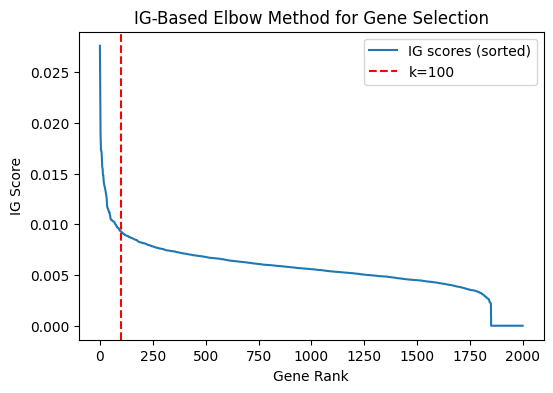

---- Final Cross-Validation on IG-Selected Genes ----
Fold Done (acc=0.542,spec={0: 0.9333333333333333, 1: 0.375, 2: 1.0},sens={0: 0.4444444444444444, 1: 1.0, 2: 0.14285714285714285},mean_sens=0.529, mean_spec=0.769)
Fold Done (acc=0.304,spec={0: 0.6363636363636364, 1: 0.4375, 2: 0.8421052631578947},sens={0: 0.4166666666666667, 1: 0.0, 2: 0.5},mean_sens=0.306, mean_spec=0.639)
Fold Done (acc=0.261,spec={0: 0.46153846153846156, 1: 0.5333333333333333, 2: 0.8333333333333334},sens={0: 0.5, 1: 0.125, 2: 0.0},mean_sens=0.208, mean_spec=0.609)
Fold Done (acc=0.522,spec={0: 0.5384615384615384, 1: 0.75, 2: 0.9411764705882353},sens={0: 0.9, 1: 0.42857142857142855, 2: 0.0},mean_sens=0.443, mean_spec=0.743)
Fold Done (acc=0.478,spec={0: 0.5333333333333333, 1: 0.6428571428571429, 2: 1.0},sens={0: 0.625, 1: 0.4444444444444444, 2: 0.3333333333333333},mean_sens=0.468, mean_spec=0.725)

=== Cross-Validation Summary (5-fold) ===
Mean Val Acc: 0.4214
Mean Loss: 1.6645
Mean Sensitivity: 0.3907
Mean Specif

In [213]:
train_data = pd.read_csv('train_mi_data.csv', index_col=None)

# Separate features (genes) and labels
X_df = train_data.drop(columns=['sample', 'disease_state'])

label_map = {
    'S-MCI': 1,
    'P-MCI': 2,
    'AD': 0
}

y = train_data['disease_state']
y_int = y.replace(label_map).astype(int).values   # numpy array
X_np_raw = X_df.values.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np_raw)         # already numpy
print(f"Training data shape: {X_scaled.shape}, Labels shape: {y_int.shape}")
X_np = X_scaled.astype(np.float32)     # safe conversion
y_np = y_int.astype(np.int64)
print(f"Classify:  {np.unique(y_np, return_counts=True)} clases")

# Step 1 — CV to train multiple CNNs
fold_models = cross_validate_cnn(X_np, y_np, k_folds=5, epochs=50)

# Step 2 — Compute global IG scores
ig_scores = compute_global_ig(fold_models, X_np, y_np)

# Step 3 — Automatic optimal k using IG-elbow
k_opt = find_optimal_k(ig_scores)

# Step 4 — Reduce dataset to top-k genes
X_reduced, selected_idx = reduce_genes(X_np, ig_scores, 100)

# Step 5 — Train final CNN on IG-selected genes
final_model_task2 = train_final_cnn_cv(X_reduced, y_np, epochs=50)


In [218]:
ad_spec = np.mean([0.9333333333333333, 0.6363636363636364, 0.46153846153846156, 0.5384615384615384, 0.5333333333333333])
print("AD spec:", ad_spec)
smci_spec =  np.mean([0.375, 0.4375, 0.5333333333333333,0.75, 0.6428571428571429 ])
print("SMCI spec:", smci_spec)
pmci_spec =  np.mean([1.0, 0.8421052631578947, 0.8333333333333334, 0.9411764705882353, 1.0])
print("PMCI spec:", pmci_spec)

ad_sen =  np.mean([0.4444444444444444,0.4166666666666667, 0.5, 0.9, 0.625])
print("AD sen:", ad_sen)
smci_sen =  np.mean([1.0,0.0, 0.125,  0.42857142857142855, 0.4444444444444444])
print("SMCI sen:", smci_sen)
pmci_sen =  np.mean([0.14285714285714285,0.5, 0.0,  0.0, 0.3333333333333333])
print("PMCI sen:",pmci_sen)

AD spec: 0.6206060606060606
SMCI spec: 0.5477380952380952
PMCI spec: 0.9233230134158926
AD sen: 0.5772222222222222
SMCI sen: 0.3996031746031746
PMCI sen: 0.1952380952380952


In [214]:
gene_cols = X_df.columns.tolist()

top_genes = [gene_cols[i] for i in selected_idx]
print(f"Top IG-selected genes: {len(top_genes)} \n {top_genes}")
sorted_ig = np.sort(ig_scores[selected_idx])[::-1]
top_k_task2 = pd.DataFrame({'gene_id': top_genes, 'ig_score': sorted_ig[:200]})

top_k_task2.to_csv('top_ig_genes_task2.csv', index=False)

Top IG-selected genes: 100 
 ['ENSG00000229637', 'ENSG00000284631', 'ENSG00000259303', 'ENSG00000161849', 'ENSG00000179546', 'ENSG00000166840', 'ENSG00000186340', 'ENSG00000214026', 'ENSG00000074416', 'ENSG00000094661', 'ENSG00000169429', 'ENSG00000166363', 'ENSG00000101680', 'ENSG00000283496', 'ENSG00000094963', 'ENSG00000002746', 'ENSG00000164107', 'ENSG00000174442', 'ENSG00000162365', 'ENSG00000113100', 'ENSG00000189171', 'ENSG00000121207', 'ENSG00000211967', 'ENSG00000277150', 'ENSG00000167264', 'ENSG00000113739', 'ENSG00000147649', 'ENSG00000146453', 'ENSG00000182256', 'ENSG00000183054', 'ENSG00000176988', 'ENSG00000196620', 'ENSG00000242498', 'ENSG00000244122', 'ENSG00000160813', 'ENSG00000161798', 'ENSG00000137090', 'ENSG00000165175', 'ENSG00000160213', 'ENSG00000242114', 'ENSG00000197548', 'ENSG00000005421', 'ENSG00000185220', 'ENSG00000183778', 'ENSG00000280416', 'ENSG00000175619', 'ENSG00000107159', 'ENSG00000244731', 'ENSG00000102055', 'ENSG00000100625', 'ENSG00000124215', '

### Evaluation

In [215]:
from sklearn.metrics import confusion_matrix, accuracy_score

def test_cnn(model, test_loader, device, positive_class=1):
    """
    Evaluates a trained CNN model on test data.

    Args:
        model: trained PyTorch model
        test_loader: DataLoader for test dataset
        device: 'cuda' or 'cpu'
        positive_class: int, class for sensitivity/specificity

    Returns:
        metrics: dict with accuracy, sensitivity, specificity, confusion matrix
        y_true: true labels (numpy)
        y_pred: predicted labels (numpy)
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    print(f"Raw predicted labels: {np.unique(y_pred, return_counts=True)}")
    label_map = {
        1:1,
        2:1,
        0:0
    }
    y_pred = np.array([label_map[label] for label in y_pred])
    print(f"Prediction class: {np.unique(y_pred, return_counts=True)}")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Sensitivity & Specificity for the selected class
    pos_mask = (y_true == positive_class)
    pred_pos_mask = (y_pred == positive_class)

    TP = np.sum(pos_mask & pred_pos_mask)
    FN = np.sum(pos_mask & (~pred_pos_mask))
    TN = np.sum((~pos_mask) & (~pred_pos_mask))
    FP = np.sum((~pos_mask) & pred_pos_mask)

    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    metrics = {
        "accuracy": acc,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm
    }

    return metrics, y_true, y_pred


Test data shape: (41, 100), Labels shape: (41,)
Raw predicted labels: (array([0, 1, 2]), array([21, 19,  1]))
Prediction class: (array([0, 1]), array([21, 20]))
Test Accuracy: 0.36585365853658536
Sensitivity: 0.0
Specificity: 0.9999999997560975
Confusion Matrix:
 [[ 8 13]
 [13  7]]


/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_65674/2355848397.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_int = y.replace(label_map).astype(int).values   # numpy array


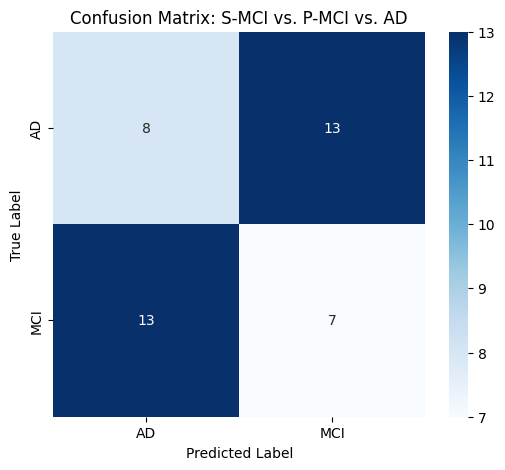

In [216]:
test_data = pd.read_csv('test_mi_data.csv', index_col=None)
X_df = test_data.drop(columns=['sample', 'disease_state'])
X_df = X_df[top_genes]  # select only IG-chosen genes
label_map = {
    'MCI':1,
    'AD': 0
}
y = test_data['disease_state']
y_int = y.replace(label_map).astype(int).values   # numpy array

X_np_raw = X_df.values.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np_raw)         # already numpy
print(f"Test data shape: {X_scaled.shape}, Labels shape: {y_int.shape}")
X_test_np = X_scaled.astype(np.float32)     # safe conversion
y_test_np = y_int.astype(np.int64)


# Assuming X_test_np, y_test_np are NumPy arrays
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Load best model
model = final_model_task2[0]
# model = CNN_1D(num_classes=len(np.unique(y_test_np)))
# model.load_state_dict(torch.load("best_model.pth"))
model.to(device)

metrics, y_true, y_pred = test_cnn(model, test_loader, device, positive_class=2)

print("Test Accuracy:", metrics["accuracy"])
print("Sensitivity:", metrics["sensitivity"])
print("Specificity:", metrics["specificity"])
print("Confusion Matrix:\n", metrics["confusion_matrix"])

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(metrics["confusion_matrix"], annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"AD", f"MCI"],
            yticklabels=[f"AD", f"MCI"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: S-MCI vs. P-MCI vs. AD')
plt.show()

## Compare genes

# Old

In [3]:
def plot_confusion_matrix_from_metrics(metrics, class_names=('Negative','Positive')):
    """
    metrics: dict containing tp, tn, fp, fn
    class_names: tuple/list with 2 class labels (negative_class, positive_class)
    """

    tn = metrics['tn']
    fp = metrics['fp']
    fn = metrics['fn']
    tp = metrics['tp']

    # Confusion matrix in standard format:
    #        Pred 0   Pred 1
    # True 0   TN       FP
    # True 1   FN       TP
    cm = np.array([[tn, fp],
                   [fn, tp]])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"Pred {class_names[0]}", f"Pred {class_names[1]}"],
                yticklabels=[f"True {class_names[0]}", f"True {class_names[1]}"])

    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

In [17]:
"""
- StratifiedKFold (K=5)
- Trains 1D-CNN and 2D-CNN separately
- Early stopping (patience=10) by validation loss
- Integrated Gradients (IG_steps=20) aggregated across folds
- Computes Accuracy, Sensitivity (TPR), Specificity (TNR) per fold and averaged
- Saves 'ig_aggregated_results.csv' with IG for both models
"""

# ---------------- Settings ----------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ---------- Data utilities ----------
def load_and_select_mci(csv_path: str, dataset_type: str):
    df = pd.read_csv(csv_path)
    if dataset_type == 'train':
        # Remove AD samples from training data
        df = df[~df['disease_state'].astype(str).str.contains('AD', case=False, na=False)].copy()
    # Heuristic: meta columns that are not genes
    meta_cols = {'samples','sample','disease_state','disease','age','Sex','sex','gender','label'}
    gene_cols = [c for c in df.columns if c not in meta_cols]
    if dataset_type == 'train':
        label_map = {'S-MCI': 0, 'P-MCI': 1} 
    else:
        label_map = {'MCI':0, 'AD':1} 
    labels = df['disease_state'].map(lambda s: label_map.get(s, s))
    if labels.dtype == object:
        le = LabelEncoder()
        y = le.fit_transform(labels)
    else:
        y = labels.astype(int).values
    X = df[gene_cols].astype(float).values
    return X, y, gene_cols

class NumpyDataset(Dataset):
    def __init__(self, X, y):
        # convert to torch tensors immediately for DataLoader convenience
        self.X = torch.from_numpy(np.asarray(X)).float()
        self.y = torch.from_numpy(np.asarray(y)).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ---------- Models ----------
class CNN1D(nn.Module):
    def __init__(self, seq_len, n_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=32,
            # kernel_size=71,
            kernel_size=15,
            stride=1
        )
        self.pool = nn.MaxPool1d(kernel_size=2)
        with torch.no_grad():
            dummy = torch.zeros(1, 1, seq_len)
            out = self.pool(F.relu(self.conv1(dummy)))
            flat_dim = out.numel()
        self.fc1 = nn.Linear(flat_dim, 128)
        self.fc2 = nn.Linear(128, n_classes)
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.flatten(1)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        return x

class CNN2D(nn.Module):
    def __init__(self, in_ch=1, side=450, n_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, 32, kernel_size=(3, 3),
                                padding=(1, 1))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2)) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), 
                               padding=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))  
        with torch.no_grad():
            dummy = torch.zeros(1, in_ch, side, side)
            out = self.pool1(F.relu(self.conv1(dummy)))
            out = self.pool2(F.relu(self.conv2(out)))
            flat_dim = out.numel()
        self.fc1 = nn.Linear(flat_dim, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)     
        return x

# ---------- Helpers ----------
def pad_to_square_length(n_features):
    side = math.ceil(math.sqrt(n_features))
    return side, side*side

def reshape_to_2d(X, side):
    # X shape (n_samples, n_features), pad to side*side, reshape to (n,1,side,side)
    n, f = X.shape
    target = side*side
    Xp = np.zeros((n, target), dtype=X.dtype)
    Xp[:, :f] = X
    Xp = Xp.reshape(n, 1, side, side)
    return Xp

# ---------- Training / evaluation ----------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    losses=[]
    preds=[]
    trues=[]
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        preds.extend(logits.argmax(dim=1).cpu().numpy().tolist())
        trues.extend(yb.cpu().numpy().tolist())
    return np.mean(losses), accuracy_score(trues, preds)

def predict_on_loader(model, loader):
    model.eval()
    probs=[]
    preds=[]
    trues=[]
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            logits = model(xb)
            probs.extend(F.softmax(logits, dim=1)[:,1].cpu().numpy().tolist())
            preds.extend(logits.argmax(dim=1).cpu().numpy().tolist())
            trues.extend(yb.cpu().numpy().tolist())
    return np.array(preds), np.array(trues), np.array(probs)

def compute_confusion_metrics(y_true, y_pred, positive_label=1):
    # returns accuracy, sensitivity (TPR), specificity (TNR)
    tp = int(((y_pred == positive_label) & (y_true == positive_label)).sum())
    tn = int(((y_pred != positive_label) & (y_true != positive_label)).sum())
    fp = int(((y_pred == positive_label) & (y_true != positive_label)).sum())
    fn = int(((y_pred != positive_label) & (y_true == positive_label)).sum())
    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total > 0 else float('nan')
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    return accuracy, sensitivity, specificity, tp, tn, fp, fn

# ---------- Integrated Gradients ----------
def integrated_gradients(model, input_tensor, target_class, baseline=None, steps=50):
    """
    input_tensor: torch.Tensor with batch dim (1, ...) on DEVICE
    baseline: same shape as input_tensor (if None -> zeros)
    returns IG attribution tensor same shape as input_tensor
    """
    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(input_tensor).to(DEVICE)
    # create scaled inputs including baseline and the input
    scaled_inputs = [baseline + (float(i) / steps) * (input_tensor - baseline) for i in range(0, steps+1)]
    grads = []
    for scaled in scaled_inputs:
        scaled = scaled.clone().detach().requires_grad_(True)
        out = model(scaled)
        score = out[0, target_class]
        model.zero_grad()
        score.backward()
        # scaled.grad is available
        grads.append(scaled.grad.detach().clone())
    grads = torch.stack(grads, dim=0)  # (steps+1, batch, ...)
    # average grads across steps (exclude the last or average all; here average across 0..steps-1)
    avg_grads = grads[:-1].mean(dim=0)
    ig = (input_tensor - baseline) * avg_grads
    return ig.detach()

# ---------- Cross-validation loop & IG aggregation (with early stopping & metrics) ----------
def run_cv_and_ig(
        X, y, gene_cols, model_type='1d',
        n_splits=5, epochs=100, batch_size=16,
        lr=1e-3, ig_steps=20, top_k=30, patience=10):

    os.makedirs("models", exist_ok=True)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    n_features = X.shape[1]

    ig_accumulator = np.zeros(n_features, dtype=float)
    fold_cnt = 0

    acc_list, sens_list, spec_list = [], [], []

    # ---- Track global best model across folds ----
    best_overall_auc = -np.inf
    best_model_path = None
    best_scaler_path = None

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # ----- Fit scaler on train fold -----
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_val_s = scaler.transform(X_val)

        # Save the scaler for this fold
        # scaler_path = f"models/scaler_fold_{fold}_{model_type}.pkl"
        # joblib.dump(scaler, scaler_path)
        # print(f"Scaler saved: {scaler_path}")

        # ----- Prepare data -----
        if model_type == "1d":
            train_ds = NumpyDataset(X_train_s, y_train)
            val_ds = NumpyDataset(X_val_s, y_val)
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
            model = CNN1D(seq_len=n_features, n_classes=len(np.unique(y))).to(DEVICE)

        elif model_type == "2d":
            side, _ = pad_to_square_length(n_features)
            X_train_2d = reshape_to_2d(X_train_s, side)
            X_val_2d = reshape_to_2d(X_val_s, side)

            train_ds = NumpyDataset(X_train_2d, y_train)
            val_ds = NumpyDataset(X_val_2d, y_val)
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
            model = CNN2D(in_ch=1,side=side, n_classes=len(np.unique(y))).to(DEVICE)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

        best_val_loss = float("inf")
        best_state = None
        epochs_no_improve = 0
        best_val_auc_fold = -np.inf  # we will track per-fold AUC

        # For IG baseline: compute train mean (in model input shape)
        train_mean = X_train_s.mean(axis=0).astype(np.float32)
        if model_type == "1d":
            baseline_template = torch.tensor(train_mean, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)  # (1,1,seq)
        else:
            baseline_2d = np.zeros(side*side, dtype=np.float32)
            baseline_2d[:n_features] = train_mean
            baseline_template = torch.tensor(baseline_2d.reshape(1,1,side,side), dtype=torch.float32).to(DEVICE)


        # ----------- Training Loop -----------
        for epoch in range(1, epochs+1):
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)

            # Compute validation loss
            model.eval()
            val_losses = []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    logits = model(xb)
                    val_losses.append(criterion(logits, yb).item())
            val_loss = np.mean(val_losses)

            # Compute AUC for monitoring
            preds_val, trues_val, probs_val = predict_on_loader(model, val_loader)
            try:
                val_auc = roc_auc_score(trues_val, probs_val)
            except:
                val_auc = float("nan")

            # Save model if best loss
            if val_loss < best_val_loss - 1e-6:
                best_val_loss = val_loss
                best_state = {k: v.cpu() for k,v in model.state_dict().items()}
                best_val_auc_fold = val_auc
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epoch % 5 == 0:
                print(f"Epoch {epoch:03d} | train loss={train_loss:.4f} acc={train_acc:.3f} "
                      f"| val loss={val_loss:.4f} AUC={val_auc:.3f} (no_improve={epochs_no_improve})")

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # ---------- Save fold best model ----------
        # fold_model_path = f"models/best_model_fold_{fold}_{model_type}.pth"
        # torch.save(best_state, fold_model_path)
        # print(f"Saved fold best model → {fold_model_path}")

        # ---------- Update global best model ----------
        if best_val_auc_fold > best_overall_auc:
            best_overall_auc = best_val_auc_fold
            best_model_path = f"models/best_model_overall_{model_type}.pth"
            best_scaler_path = f"models/best_scaler_overall_{model_type}.pkl"

            torch.save(best_state, best_model_path)
            joblib.dump(scaler, best_scaler_path)

            print(f"★ Updated GLOBAL BEST MODEL (AUC={best_val_auc_fold:.4f})")
            print(f"→ Saved: {best_model_path}")
            print(f"→ Saved: {best_scaler_path}")

        # ---------- Compute metrics ----------
        model.load_state_dict(best_state)
        preds_val, trues_val, probs_val = predict_on_loader(model, val_loader)
        try:
            val_auc = roc_auc_score(trues_val, probs_val)
        except:
            val_auc = float('nan')

        acc, sens, spec, tp, tn, fp, fn = compute_confusion_metrics(trues_val, preds_val, 1)
        print(f"Fold {fold} Metrics: Acc={acc:.4f} Sens={sens:.4f} Spec={spec:.4f} AUC={val_auc:.4f}")

        acc_list.append(acc)
        sens_list.append(sens)
        spec_list.append(spec)

        # ---------- Integrated Gradients ----------
        model.eval()
        ig_sum_fold = np.zeros(n_features if model_type=='1d' else side*side, dtype=float)
        n_val = 0

        # compute IG per validation sample (no global torch.no_grad because IG requires grads)
        for i in range(len(val_ds)):
            x_tensor, y_true = val_ds[i]  # x_tensor is torch tensor on CPU
            # move to device and add batch dim
            x_tensor = x_tensor.unsqueeze(0).to(DEVICE)
            x_tensor = x_tensor.clone().detach().requires_grad_(True)
            # predict class to use as target
            logits = model(x_tensor)
            target_class = int(logits.argmax(dim=1).item())
            ig_tensor = integrated_gradients(model, x_tensor, target_class, baseline=torch.zeros_like(x_tensor).to(DEVICE), steps=ig_steps)
            if model_type == '1d':
                ig_vec = ig_tensor.squeeze(0).cpu().numpy()  # (seq_len,)
                ig_sum_fold[:n_features] += ig_vec[:n_features]
            else:
                ig_vec = ig_tensor.squeeze(0).view(-1).cpu().numpy()  # length side*side
                ig_sum_fold += ig_vec
            n_val += 1

        ig_fold_avg = ig_sum_fold / n_val if n_val>0 else ig_sum_fold
        # map to original features
        if model_type == '2d':
            ig_orig = ig_fold_avg[:n_features]
        else:
            ig_orig = ig_fold_avg

        ig_accumulator += ig_orig
        fold_cnt += 1

    # ----- Final IG ranking -----
    if fold_cnt == 0:
        raise RuntimeError("No folds completed successfully; fold_cnt == 0")

    ig_avg = ig_accumulator / fold_cnt  # average across folds

    # safe normalization of absolute IG
    ig_avg = ig_accumulator / fold_cnt
    ig_abs = np.abs(ig_avg)
    ig_norm = (ig_abs - ig_abs.min()) / (ig_abs.max() - ig_abs.min() + 1e-12)
    order = np.argsort(-ig_norm)
    top_k = min(top_k, len(ig_norm))
    top_idx = order[:top_k]

    # Ranking
    order = np.argsort(-ig_norm)
    top_idx = order[:min(top_k, len(order))]

    metrics = {
        "mean_accuracy": float(np.nanmean(acc_list)),
        "mean_sensitivity": float(np.nanmean(sens_list)),
        "mean_specificity": float(np.nanmean(spec_list)),
        "per_fold_accuracy": acc_list,
        "per_fold_sensitivity": sens_list,
        "per_fold_specificity": spec_list,
        "best_model_path": best_model_path,
        "best_scaler_path": best_scaler_path
    }

    print("\n=== GLOBAL BEST MODEL ===")
    print("Model:", best_model_path)
    print("Scaler:", best_scaler_path)

    return ig_norm, top_idx, metrics

In [102]:
model_1D = CNN1D(seq_len=450, n_classes=2)
model_2D = CNN2D(in_ch=1, side=450, n_classes=2)
print(model_1D)
print(model_2D)

CNN1D(
  (conv1): Conv1d(1, 32, kernel_size=(71,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6080, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
CNN2D(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=802816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [96]:
# ---------- Training script ----------
batch_size = 16
num_epochs = 100
learning_rate = 1e-3
ig_steps = 20
top_k = 10
patience = 10

X, y, gene_cols = load_and_select_mci('train_normalized_data.csv',dataset_type='train')
print("Data loaded. Samples:", X.shape[0], "Genes:", X.shape[1])
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))
if len(np.unique(y)) != 2:
    raise ValueError("This pipeline expects a binary classification (2 classes). Found: " + str(np.unique(y)))

results = {}
for m in ['1d', '2d']:
    print(f"\n### Running model: {m} ###")
    ig_norm, top_idx, metrics = run_cv_and_ig(X, y, gene_cols,
                                                model_type=m,
                                                n_splits=5,
                                                epochs=num_epochs,
                                                batch_size=batch_size,
                                                lr=learning_rate,
                                                ig_steps=ig_steps,
                                                top_k=top_k,
                                                patience=patience)
    top_genes = [gene_cols[i] for i in top_idx]
    top_scores = ig_norm[top_idx]
    print(f"\nTop-{len(top_genes)} genes for model {m}:")
    for g, s in zip(top_genes, top_scores):
        print(f"{g}\t{s:.4f}")

    print(f"\nAggregated metrics for model {m}:")
    print(f"Mean Accuracy: {metrics['mean_accuracy']:.4f}")
    print(f"Mean Sensitivity (TPR): {metrics['mean_sensitivity']:.4f}")
    print(f"Mean Specificity (TNR): {metrics['mean_specificity']:.4f}")
    results[m] = {'ig_norm': ig_norm, 'top_genes': top_genes, 'top_scores': top_scores, 'metrics': metrics}

# Save results
out_df_1d = pd.DataFrame({'gene': gene_cols, 'ig_1d': results['1d']['ig_norm']})
out_df_2d = pd.DataFrame({'gene': gene_cols, 'ig_2d': results['2d']['ig_norm']})
out_df = out_df_1d.merge(out_df_2d, on='gene')
out_df.to_csv('ig_aggregated_results.csv', index=False)
print("\nSaved ig_aggregated_results.csv")

Data loaded. Samples: 67 Genes: 450
Class distribution: {0: 39, 1: 28}

### Running model: 1d ###

--- Fold 1/5 ---
Epoch 005 | train loss=0.5846 acc=0.811 | val loss=0.7158 AUC=0.708 (no_improve=1)
Epoch 010 | train loss=0.2085 acc=0.981 | val loss=0.6257 AUC=0.812 (no_improve=1)
Epoch 015 | train loss=0.0531 acc=1.000 | val loss=0.6655 AUC=0.792 (no_improve=6)
Early stopping at epoch 19
★ Updated GLOBAL BEST MODEL (AUC=0.7917)
→ Saved: models/best_model_overall_1d.pth
→ Saved: models/best_scaler_overall_1d.pkl
Fold 1 Metrics: Acc=0.7143 Sens=0.5000 Spec=0.8750 AUC=0.8125

--- Fold 2/5 ---
Epoch 005 | train loss=0.4175 acc=0.887 | val loss=0.6348 AUC=0.667 (no_improve=1)
Epoch 010 | train loss=0.1120 acc=1.000 | val loss=0.8733 AUC=0.708 (no_improve=6)
Early stopping at epoch 14
Fold 2 Metrics: Acc=0.5714 Sens=0.3333 Spec=0.7500 AUC=0.6875

--- Fold 3/5 ---
Epoch 005 | train loss=0.6770 acc=0.593 | val loss=0.6870 AUC=0.714 (no_improve=0)
Epoch 010 | train loss=0.6064 acc=0.593 | val 

#### Merge gene symbol

In [14]:
gene_names = pd.read_csv('gene_id_and_gene_symbols.csv')
gene_names.drop(columns=['ig_1d'], inplace=True)
ig_output = pd.read_csv('ig_aggregated_results.csv')
mergeed = pd.merge(ig_output, gene_names, on='gene_id', how='left')
# mergeed.to_csv('ig_aggregated_results_with_symbol.csv', index=False)
print(mergeed.head())

mergeed.sort_values(by=['ig_1d'], ascending=False, inplace=True)
top_1D = mergeed[['gene_id','ig_1d','gene_symbol']].copy()
# Top 10 genes with symbols
print("Top 10 genes with symbols for 1D-CNN:")
display(top_1D.head(30))
top_1D.to_csv('biomarker_1D.csv', index=False)

mergeed.sort_values(by=['ig_2d'], ascending=False, inplace=True)
top_2D = mergeed[['gene_id','ig_2d','gene_symbol']].copy()
# Top 10 genes with symbols
print("Top 10 genes with symbols for 2D-CNN:")
display(top_2D.head(30))
top_2D.to_csv('biomarker_2D.csv', index=False)

           gene_id     ig_1d     ig_2d           gene_symbol
0  ENSG00000115590  0.010339  0.035513                 IL1R2
1  ENSG00000198502  0.010407  0.085344              HLA-DRB5
2  ENSG00000182557  0.012079  0.088396                 SPNS3
3  ENSG00000260537  0.002391  0.188524  gene:ENSG00000260537
4  ENSG00000112759  0.002643  0.043546               SLC29A1
Top 10 genes with symbols for 1D-CNN:


,gene_id,ig_1d,gene_symbol
205,ENSG00000243264,1.000000,IGKV2D-29
192,ENSG00000270757,0.946433,HSPE1-MOB4
217,ENSG00000211668,0.898829,IGLV2-11
338,ENSG00000160221,0.866197,GATD3A
310,ENSG00000145632,0.852291,PLK2
158,ENSG00000211898,0.816777,IGHD
204,ENSG00000169429,0.800145,CXCL8
358,ENSG00000211716,0.776528,TRBV9
248,ENSG00000197061,0.671272,H4C3
142,ENSG00000276775,0.618931,IGHV4-4


Top 10 genes with symbols for 2D-CNN:


,gene_id,ig_2d,gene_symbol
248,ENSG00000197061,1.000000,H4C3
249,ENSG00000124575,0.863159,H1-3
310,ENSG00000145632,0.828135,PLK2
158,ENSG00000211898,0.819881,IGHD
157,ENSG00000188157,0.704535,AGRN
202,ENSG00000104728,0.689622,ARHGEF10
225,ENSG00000211721,0.683682,TRBV6-5
179,ENSG00000100376,0.674284,FAM118A
353,ENSG00000257411,0.656874,gene:ENSG00000257411
180,ENSG00000211638,0.646989,IGLV8-61


### External Evaluation

In [12]:
import joblib
import os

def evaluate_on_external(
    external_csv_path,
    model_path,
    dataset_type='test',
    model_type='1d',
    gene_selector=None,
    scaler_path=None,
    device=DEVICE,
    batch_size=16,
):
    """
    Evaluate a saved model state_dict on an external CSV.

    Args:
        external_csv_path: path to CSV with gene columns + disease_state column
        model_path: path to saved state_dict (torch.save(state_dict, path))
        dataset_type: 'train' or other (affects label mapping inside load_and_select_mci)
        model_type: '1d' or '2d'
        gene_selector: optional list of gene column names to select/ reorder (if None use all non-meta)
        scaler_path: optional path to a saved StandardScaler (joblib). If None, scaler will be fit on external X (warning).
        device: torch device
        batch_size: DataLoader batch size

    Returns:
        dict metrics, path to saved predictions CSV
    """
    # load external data
    X_ext, y_ext, gene_cols_ext = load_and_select_mci(external_csv_path, dataset_type)
    print("Data loaded. Samples:", X_ext.shape[0], "Genes:", X_ext.shape[1])
    unique, counts = np.unique(y_ext, return_counts=True)
    print("Class distribution:", dict(zip(unique, counts)))
    

    # If user provided a gene selector, check and reorder/select columns
    if gene_selector is not None:
        # gene_selector should be a list of column names present in gene_cols_ext
        missing = [g for g in gene_selector if g not in gene_cols_ext]
        if len(missing) > 0:
            raise ValueError(f"The following requested genes are not present in the external CSV: {missing}")
        # find indices of requested genes in original order
        idxs = [gene_cols_ext.index(g) for g in gene_selector]
        X_ext = X_ext[:, idxs]
        gene_cols_used = list(gene_selector)
    else:
        gene_cols_used = gene_cols_ext

    # Load or fit scaler
    if scaler_path is not None and os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        X_ext_s = scaler.transform(X_ext)
        print(f"Loaded scaler from {scaler_path} and transformed external data.")
    else:
        # WARNING: fitting scaler on test data is generally not recommended.
        print("Warning: no scaler_path provided or scaler not found — fitting StandardScaler on external data (this may be inappropriate if you used a training scaler during model training).")
        scaler = StandardScaler()
        X_ext_s = scaler.fit_transform(X_ext)

    n_features_ext = X_ext_s.shape[1]

    # Prepare dataset and load model
    if model_type == '1d':
        ds_ext = NumpyDataset(X_ext_s, y_ext)
        loader_ext = DataLoader(ds_ext, batch_size=batch_size, shuffle=False)
        # seq_len argument is not used inside CNN1D, but keep for clarity
        model = CNN1D(seq_len=n_features_ext, n_classes=len(np.unique(y_ext))).to(device)
    elif model_type == '2d':
        side, target = pad_to_square_length(n_features_ext)
        X_ext_2d = reshape_to_2d(X_ext_s, side)
        ds_ext = NumpyDataset(X_ext_2d, y_ext)
        loader_ext = DataLoader(ds_ext, batch_size=batch_size, shuffle=False)
        model = CNN2D(in_ch=1, side=side, n_classes=len(np.unique(y_ext))).to(device)
    else:
        raise ValueError("model_type must be '1d' or '2d'")

    # Load saved state dict
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"model_path '{model_path}' not found.")
    try:
        state = torch.load(model_path, map_location=device)
        # If the file contains a dict of tensors (state_dict), load it.
        # If the user accidentally saved the whole model, handle gracefuly.
        if isinstance(state, dict) and all(isinstance(v, torch.Tensor) for v in list(state.values())[:1]):
            model.load_state_dict(state)
        else:
            # try to handle if they saved {"epoch":..., "state_dict": ...}
            if isinstance(state, dict) and 'state_dict' in state:
                model.load_state_dict(state['state_dict'])
            else:
                # otherwise attempt to load directly (this may throw)
                model.load_state_dict(state)
    except Exception as e:
        raise RuntimeError(f"Failed to load model state_dict from {model_path}: {e}")

    model.to(device)
    model.eval()

    # Run predictions
    preds, trues, probs = predict_on_loader(model, loader_ext)

    # Compute metrics
    acc, sens, spec, tp, tn, fp, fn = compute_confusion_metrics(trues, preds, positive_label=1)
    # print(confusion_matrix(trues, preds), '\n')
    # print(classification_report(trues, preds, digits=4))
    
    try:
        auc = roc_auc_score(trues, probs)
    except Exception:
        auc = float('nan')

    metrics = {
        'accuracy': acc,
        'sensitivity': sens,
        'specificity': spec,
        'auc': auc,
        'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
    }

    # Save predictions csv next to external csv with model basename
    model_basename = os.path.splitext(os.path.basename(model_path))[0]
    out_csv = os.path.splitext(external_csv_path)[0] + f"_preds_{model_basename}.csv"
    out_df = pd.DataFrame({
        'true': trues.astype(int),
        'pred': preds.astype(int),
        'prob_pos': probs.astype(float)
    })
    out_df.to_csv(out_csv, index=False)

    print("External evaluation metrics:", metrics)
    print("Saved predictions to:", out_csv)
    return metrics, out_csv

In [16]:
# ---------- Evaluation script ----------
metrics_1D = evaluate_on_external(
    external_csv_path="test_normalized_data.csv",
    model_path="models/best_model_overall_1d.pth",
    scaler_path="models/best_scaler_overall_1d.pkl",
    model_type="1d"
)


metrics_2D = evaluate_on_external(
    external_csv_path="test_normalized_data.csv",
    model_path="models/best_model_overall_2d.pth",
    scaler_path="models/best_scaler_overall_2d.pkl",
    model_type="2d"
)

Data loaded. Samples: 41 Genes: 450
Class distribution: {0: 20, 1: 21}
Loaded scaler from models/best_scaler_overall_1d.pkl and transformed external data.
External evaluation metrics: {'accuracy': 0.5365853658536586, 'sensitivity': 0.23809523809523808, 'specificity': 0.85, 'auc': 0.4238095238095238, 'tp': 5, 'tn': 17, 'fp': 3, 'fn': 16}
Saved predictions to: test_normalized_data_preds_best_model_overall_1d.csv
Data loaded. Samples: 41 Genes: 450
Class distribution: {0: 20, 1: 21}
Loaded scaler from models/best_scaler_overall_2d.pkl and transformed external data.
External evaluation metrics: {'accuracy': 0.4878048780487805, 'sensitivity': 0.0, 'specificity': 1.0, 'auc': 0.5, 'tp': 0, 'tn': 20, 'fp': 0, 'fn': 21}
Saved predictions to: test_normalized_data_preds_best_model_overall_2d.csv


/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_50476/4225135924.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=

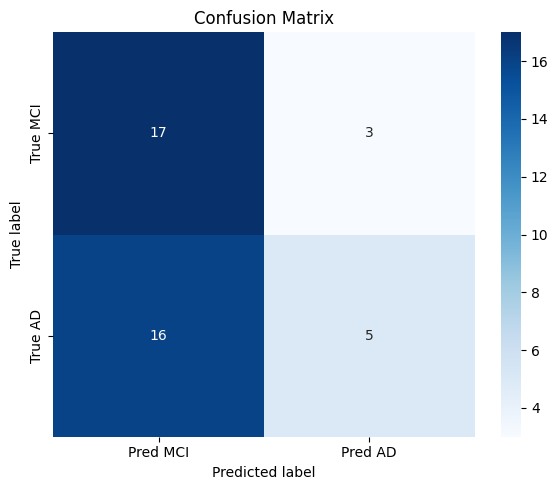

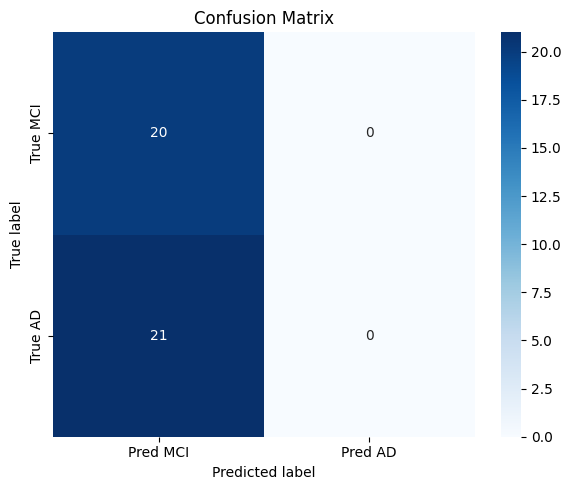

In [7]:
plot_confusion_matrix_from_metrics(metrics_1D[0], class_names=('MCI','AD'))
plot_confusion_matrix_from_metrics(metrics_2D[0], class_names=('MCI','AD'))

### Venn Diagram

In [2]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import pandas as pd

svm = pd.read_csv('svm_output/LinearSVMtop_30_gene_biomarkers_SMCI_PMCI.csv')
gene_names = pd.read_csv('gene_id_and_gene_symbols.csv')
mergeed = pd.merge(svm, gene_names, on='gene_id', how='left')
mergeed.to_csv('biomarker_svm.csv', index=False)

SVM top 30 genes: {'IGKV2D-29', 'gene:ENSG00000289491', 'TKTL1', 'CLEC4C', 'TRAV20', 'TRBV10-2', 'PF4V1', 'TRBV9', 'HBA2', 'gene:ENSG00000283149', 'gene:ENSG00000279716', 'gene:ENSG00000259132', 'IGHV1-2', 'SIGLEC14', 'IGHV4-31', 'ARHGEF10', 'gene:ENSG00000260851', 'MARCO', 'IGHV5-10-1', 'IGHV4-4', 'TRBV23-1', 'THBS1', 'FAM118A', 'BTNL3', 'TRBV25-1', 'CNTNAP3B', 'ACCS', 'ELAPOR1', 'IGKV2-24', 'TRBV27'}
CNN 1D top 30 genes: {'RASD1', 'HBB', 'FCRL2', 'IGKV2D-29', 'IGKV3-11', 'H4C3', 'TRAV20', 'PLK2', 'TRBV10-2', 'GADD45G', 'GATD3A', 'IGLV3-21', 'TRBV9', 'IGHV3-23', 'IGHD', 'IGLV1-40', 'IGHV3-13', 'FOS', 'IGLV2-11', 'G0S2', 'AZU1', 'HSPE1-MOB4', 'CD22', 'IGHV1-69', 'IGHV4-4', 'FAM118A', 'CXCL8', 'CD300LD', 'FCRL1', 'TUBB2A'}
CNN 2D top 30 genes: {'IGHV2-5', 'TRAV19', 'IGKV2D-29', 'CNTNAP3', 'gene:ENSG00000279117', 'TRDV1', 'CLEC12B', 'OAS2', 'H4C3', 'PTGDS', 'TRBV6-5', 'PLK2', 'IGHD', 'IGHV3-13', 'gene:ENSG00000279753', 'gene:ENSG00000258677', 'AGRN', 'CD177', 'H1-3', 'H2BC7', 'H2AC12', '

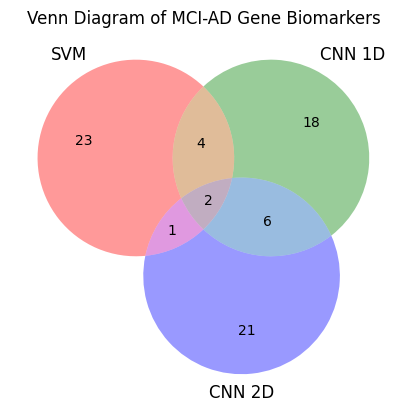

In [3]:
svm = pd.read_csv('biomarker_svm.csv').iloc[:30]
cnn_1d = pd.read_csv('biomarker_1D.csv').iloc[:30]
cnn_2d = pd.read_csv('biomarker_2D.csv').iloc[:30]

set_svm = set(svm['gene_symbol'].tolist())
set_cnn_1d = set(cnn_1d['gene_symbol'].tolist())
set_cnn_2d = set(cnn_2d['gene_symbol'].tolist())
print("SVM top 30 genes:", set_svm)
print("CNN 1D top 30 genes:", set_cnn_1d)
print("CNN 2D top 30 genes:", set_cnn_2d)
overlap_genes = set_svm & set_cnn_1d & set_cnn_2d
print("Overlapping genes in all three models:", overlap_genes)

venn3(subsets=[set_svm, set_cnn_1d, set_cnn_2d], set_labels=('SVM', 'CNN 1D', 'CNN 2D'))
plt.title("Venn Diagram of MCI-AD Gene Biomarkers")
plt.show()

### GSEA

,gene,score
0,H4C3,1.000000
1,H1-3,0.863159
2,PLK2,0.828135
3,IGHD,0.819881
4,AGRN,0.704535
5,ARHGEF10,0.689622
6,TRBV6-5,0.683682
7,FAM118A,0.674284
8,gene:ENSG00000257411,0.656874
9,IGLV8-61,0.646989


2025-11-23 21:57:27,335 [INFO] Parsing data files for GSEA.............................
2025-11-23 21:57:27,336 [INFO] Enrichr library gene sets already downloaded in: /Users/kitiya/.cache/gseapy, use local file
2025-11-23 21:57:27,357 [INFO] 0311 gene_sets have been filtered out when max_size=100 and min_size=2
2025-11-23 21:57:27,357 [INFO] 0009 gene_sets used for further statistical testing.....
2025-11-23 21:57:27,358 [INFO] Start to run GSEA...Might take a while..................
2025-11-23 21:57:27,358 [INFO] Genes are converted to uppercase.
2025-11-23 21:57:27,718 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Pathogenic Escherichia coli infection,-0.857143,-1.470947,0.072464,0.181805,0.107459,2/2,23.33%,TUBB2A;CXCL8
1,prerank,Salmonella infection,-0.857143,-1.470947,0.072464,0.181805,0.107459,2/2,23.33%,TUBB2A;CXCL8
2,prerank,Viral carcinogenesis,0.704514,1.204983,0.228715,0.843325,0.382,1/2,3.33%,H4C3
3,prerank,NOD-like receptor signaling pathway,-0.607143,-1.033943,0.483871,0.441794,0.570164,2/2,46.67%,CXCL8;OAS2
4,prerank,Coronavirus disease,-0.607143,-1.033943,0.483871,0.441794,0.570164,2/2,46.67%,CXCL8;OAS2


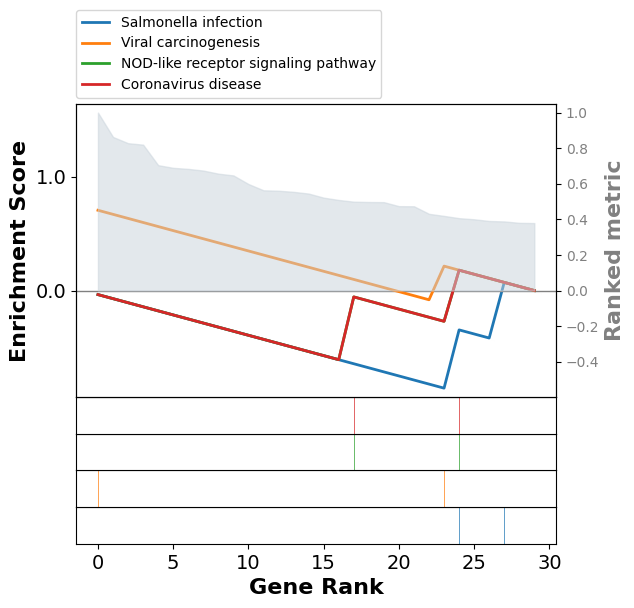

In [23]:
import gseapy as gp

# Create a ranked list DataFrame
ranked_df = pd.DataFrame({
    "gene": cnn_2d['gene_symbol'],
    "score": cnn_2d['ig_2d']
})

# Sort by descending score (most important → least)
ranked_df = ranked_df.sort_values("score", ascending=False)

# Save to file required by GSEA
ranked_df.to_csv("ranked_genes.rnk", sep="\t", header=False, index=False)
display(ranked_df.head(10))

# Run prerank GSEA
pre_res = gp.prerank(
    rnk="ranked_genes.rnk",
    gene_sets='KEGG_2021_Human', 
    outdir='gsea_results',
    min_size=2,
    max_size=100,
    permutation_num=1000,
    seed=6,
    verbose=True
)

# Display top enriched pathways
display(pre_res.res2d.head(5))

# Plot GSEA enrichment for top pathway
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[1:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

### Evaluation on the top 30 genes

In [22]:
# Filter the 450 genes to top 30 genes
def load_and_select_mci(csv_path: str, dataset_type: str, model_type: str):
    df = pd.read_csv(csv_path)
    if dataset_type == 'train':
        # Remove AD samples from training data
        df = df[~df['disease_state'].astype(str).str.contains('AD', case=False, na=False)].copy()
    # Heuristic: meta columns that are not genes
    meta_cols = {'samples','sample','disease_state','disease','age','Sex','sex','gender','label'}
    gene_cols = [c for c in df.columns if c not in meta_cols]

    # Filter to top 30 genes from 1D-CNN IG results
    if model_type == '1d':
        top_30 = pd.read_csv('biomarker_1D.csv').iloc[:30]['gene_id'].tolist() 
    else:
        top_30 = pd.read_csv('biomarker_2D.csv').iloc[:30]['gene_id'].tolist()
    gene_cols = [g for g in gene_cols if g in top_30]

    if dataset_type == 'train':
        label_map = {'S-MCI': 0, 'P-MCI': 1} 
    else:
        label_map = {'MCI':0, 'AD':1} 
    labels = df['disease_state'].map(lambda s: label_map.get(s, s))
    if labels.dtype == object:
        le = LabelEncoder()
        y = le.fit_transform(labels)
    else:
        y = labels.astype(int).values
    X = df[gene_cols].astype(float).values
    return X, y, gene_cols

X_1D, y_1D, gene_cols = load_and_select_mci('train_normalized_data.csv',dataset_type='train', model_type='1d')
print("Data loaded. Samples:", X_1D.shape[0], "Genes:", X_1D.shape[1])

Data loaded. Samples: 67 Genes: 30


In [19]:
batch_size = 16
num_epochs = 100
learning_rate = 1e-3
ig_steps = 20
top_k = 10
patience = 10

results = {}
for m in ['1d', '2d']:
    print(f"\n### Running model: {m} ###")
    ig_norm, top_idx, metrics = run_cv_and_ig(X_1D, y_1D, gene_cols,
                                                model_type=m,
                                                n_splits=5,
                                                epochs=num_epochs,
                                                batch_size=batch_size,
                                                lr=learning_rate,
                                                ig_steps=ig_steps,
                                                top_k=top_k,
                                                patience=patience)

    print(f"\nAggregated metrics for model {m}:")
    print(f"Mean Accuracy: {metrics['mean_accuracy']:.4f}")
    print(f"Mean Sensitivity (TPR): {metrics['mean_sensitivity']:.4f}")
    print(f"Mean Specificity (TNR): {metrics['mean_specificity']:.4f}")
    results[m] = {'ig_norm': ig_norm, 'metrics': metrics}


### Running model: 1d ###

--- Fold 1/5 ---
Epoch 005 | train loss=0.4551 acc=0.792 | val loss=0.5969 AUC=0.792 (no_improve=2)
Epoch 010 | train loss=0.3243 acc=0.868 | val loss=0.6183 AUC=0.750 (no_improve=4)
Epoch 015 | train loss=0.2040 acc=0.962 | val loss=0.6956 AUC=0.750 (no_improve=9)
Early stopping at epoch 16
★ Updated GLOBAL BEST MODEL (AUC=0.7917)
→ Saved: models/best_model_overall_1d.pth
→ Saved: models/best_scaler_overall_1d.pkl
Fold 1 Metrics: Acc=0.8571 Sens=0.6667 Spec=1.0000 AUC=0.7500

--- Fold 2/5 ---
Epoch 005 | train loss=0.4296 acc=0.811 | val loss=0.7918 AUC=0.646 (no_improve=4)
Epoch 010 | train loss=0.2738 acc=0.906 | val loss=0.8480 AUC=0.646 (no_improve=9)
Early stopping at epoch 11
Fold 2 Metrics: Acc=0.6429 Sens=0.6667 Spec=0.6250 AUC=0.6458

--- Fold 3/5 ---
Epoch 005 | train loss=0.4850 acc=0.796 | val loss=0.4858 AUC=0.929 (no_improve=0)
Epoch 010 | train loss=0.3636 acc=0.833 | val loss=0.4039 AUC=0.976 (no_improve=0)
Epoch 015 | train loss=0.2194 acc=

In [23]:
def evaluate_on_external(
    external_csv_path,
    model_path,
    dataset_type='test',
    model_type='1d',
    gene_selector=None,
    scaler_path=None,
    device=DEVICE,
    batch_size=16,
):
    """
    Evaluate a saved model state_dict on an external CSV.

    Args:
        external_csv_path: path to CSV with gene columns + disease_state column
        model_path: path to saved state_dict (torch.save(state_dict, path))
        dataset_type: 'train' or other (affects label mapping inside load_and_select_mci)
        model_type: '1d' or '2d'
        gene_selector: optional list of gene column names to select/ reorder (if None use all non-meta)
        scaler_path: optional path to a saved StandardScaler (joblib). If None, scaler will be fit on external X (warning).
        device: torch device
        batch_size: DataLoader batch size

    Returns:
        dict metrics, path to saved predictions CSV
    """
    # load external data
    X_ext, y_ext, gene_cols_ext = load_and_select_mci(external_csv_path, dataset_type, model_type)
    print("Data loaded. Samples:", X_ext.shape[0], "Genes:", X_ext.shape[1])
    unique, counts = np.unique(y_ext, return_counts=True)
    print("Class distribution:", dict(zip(unique, counts)))
    

    # If user provided a gene selector, check and reorder/select columns
    if gene_selector is not None:
        # gene_selector should be a list of column names present in gene_cols_ext
        missing = [g for g in gene_selector if g not in gene_cols_ext]
        if len(missing) > 0:
            raise ValueError(f"The following requested genes are not present in the external CSV: {missing}")
        # find indices of requested genes in original order
        idxs = [gene_cols_ext.index(g) for g in gene_selector]
        X_ext = X_ext[:, idxs]
        gene_cols_used = list(gene_selector)
    else:
        gene_cols_used = gene_cols_ext

    # Load or fit scaler
    if scaler_path is not None and os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        X_ext_s = scaler.transform(X_ext)
        print(f"Loaded scaler from {scaler_path} and transformed external data.")
    else:
        # WARNING: fitting scaler on test data is generally not recommended.
        print("Warning: no scaler_path provided or scaler not found — fitting StandardScaler on external data (this may be inappropriate if you used a training scaler during model training).")
        scaler = StandardScaler()
        X_ext_s = scaler.fit_transform(X_ext)

    n_features_ext = X_ext_s.shape[1]

    # Prepare dataset and load model
    if model_type == '1d':
        ds_ext = NumpyDataset(X_ext_s, y_ext)
        loader_ext = DataLoader(ds_ext, batch_size=batch_size, shuffle=False)
        # seq_len argument is not used inside CNN1D, but keep for clarity
        model = CNN1D(seq_len=n_features_ext, n_classes=len(np.unique(y_ext))).to(device)
    elif model_type == '2d':
        side, target = pad_to_square_length(n_features_ext)
        X_ext_2d = reshape_to_2d(X_ext_s, side)
        ds_ext = NumpyDataset(X_ext_2d, y_ext)
        loader_ext = DataLoader(ds_ext, batch_size=batch_size, shuffle=False)
        model = CNN2D(in_ch=1, side=side, n_classes=len(np.unique(y_ext))).to(device)
    else:
        raise ValueError("model_type must be '1d' or '2d'")

    # Load saved state dict
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"model_path '{model_path}' not found.")
    try:
        state = torch.load(model_path, map_location=device)
        # If the file contains a dict of tensors (state_dict), load it.
        # If the user accidentally saved the whole model, handle gracefuly.
        if isinstance(state, dict) and all(isinstance(v, torch.Tensor) for v in list(state.values())[:1]):
            model.load_state_dict(state)
        else:
            # try to handle if they saved {"epoch":..., "state_dict": ...}
            if isinstance(state, dict) and 'state_dict' in state:
                model.load_state_dict(state['state_dict'])
            else:
                # otherwise attempt to load directly (this may throw)
                model.load_state_dict(state)
    except Exception as e:
        raise RuntimeError(f"Failed to load model state_dict from {model_path}: {e}")

    model.to(device)
    model.eval()

    # Run predictions
    preds, trues, probs = predict_on_loader(model, loader_ext)

    # Compute metrics
    acc, sens, spec, tp, tn, fp, fn = compute_confusion_metrics(trues, preds, positive_label=1)
    # print(confusion_matrix(trues, preds), '\n')
    # print(classification_report(trues, preds, digits=4))
    
    try:
        auc = roc_auc_score(trues, probs)
    except Exception:
        auc = float('nan')

    metrics = {
        'accuracy': acc,
        'sensitivity': sens,
        'specificity': spec,
        'auc': auc,
        'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
    }

    print("External evaluation metrics:", metrics)
    return metrics

In [24]:
metrics_1D = evaluate_on_external(
    external_csv_path="test_normalized_data.csv",
    model_path="models/best_model_overall_1d.pth",
    scaler_path="models/best_scaler_overall_1d.pkl",
    model_type="1d"
)


metrics_2D = evaluate_on_external(
    external_csv_path="test_normalized_data.csv",
    model_path="models/best_model_overall_2d.pth",
    scaler_path="models/best_scaler_overall_2d.pkl",
    model_type="2d"
)

Data loaded. Samples: 41 Genes: 30
Class distribution: {0: 20, 1: 21}
Loaded scaler from models/best_scaler_overall_1d.pkl and transformed external data.
External evaluation metrics: {'accuracy': 0.4878048780487805, 'sensitivity': 0.9523809523809523, 'specificity': 0.0, 'auc': 0.519047619047619, 'tp': 20, 'tn': 0, 'fp': 20, 'fn': 1}
Data loaded. Samples: 41 Genes: 30
Class distribution: {0: 20, 1: 21}
Loaded scaler from models/best_scaler_overall_2d.pkl and transformed external data.
External evaluation metrics: {'accuracy': 0.4634146341463415, 'sensitivity': 0.8571428571428571, 'specificity': 0.05, 'auc': 0.4619047619047619, 'tp': 18, 'tn': 1, 'fp': 19, 'fn': 3}


/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_34567/422202816.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=d